In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110851 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [0]:
from urllib.request import urlopen
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt


def lossFun(inputs, targets, hprev):
  """
  inputs,targets are both list of integers.
  hprev is Hx1 array of initial hidden state
  returns the loss, gradients on model parameters, and last hidden state
  """
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0
  # forward pass
  for t in range(len(inputs)):
    xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][inputs[t]] = 1
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
  # backward pass: compute gradients going backwards
  dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
  dbh, dby = np.zeros_like(bh), np.zeros_like(by)
  dhnext = np.zeros_like(hs[0])
  for t in reversed(range(len(inputs))):
    dy = np.copy(ps[t])
    dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
    dWhy += np.dot(dy, hs[t].T)
    dby += dy
    dh = np.dot(Why.T, dy) + dhnext # backprop into h
    dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
    dbh += dhraw
    dWxh += np.dot(dhraw, xs[t].T)
    dWhh += np.dot(dhraw, hs[t-1].T)
    dhnext = np.dot(Whh.T, dhraw)
  for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
  return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

def sample(h, seed_ix, n):
  """ 
  sample a sequence of integers from the model 
  h is memory state, seed_ix is seed letter for first time step
  """
  x = np.zeros((vocab_size, 1))
  x[seed_ix] = 1
  ixes = []
  for t in range(n):
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    y = np.dot(Why, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)
  return ixes

In [0]:
"""
Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
BSD License
"""

# data I/O
data = open('drive/Colab Notebooks/quijote.txt', 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print ('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# hyperparameters
hidden_size = 100 # size of hidden layer of neurons -- original was 100
seq_length = 50 # number of steps to unroll the RNN for -- original value was 25
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

data has 1351990 characters, 80 unique.


In [0]:
# Getting back the objects:
import pickle

with open('drive/Colab Notebooks/objs.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    n, p, costs, loss, hprev, smooth_loss, param, dparam, mem, Wxh, Whh, Why, bh, by, dWxh, dWhh, dWhy, dbh, dby, mWxh, mWhh, mWhy, mbh, mby = pickle.load(f)

print ('n=', n)

n= 2703980


In [0]:
# Learn for the first time

n, p = 0, 0

mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

costs = []

 Iteration 500000 Loss: 39.9108520704656

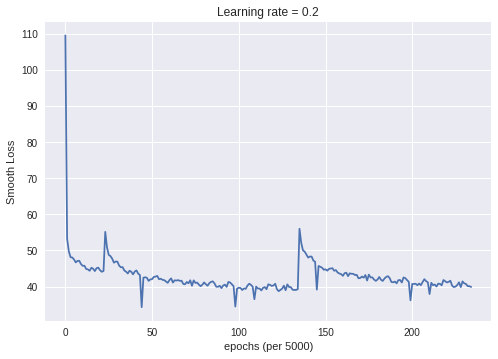

In [0]:
learning_rate = 2e-1

for n in range(500001):
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  if p+seq_length+1 >= len(data) or n == 0: 
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    p = 0 # go from start of data
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

  # sample from the model now and then
  #if n % 2000 == 0:
    #sample_ix = sample(hprev, inputs[0], 1500)
    #txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    #print ('----\n %s \n----' % (txt, ))

  # forward seq_length characters through the net and fetch gradient
  loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  if n % 5000 == 0:
        clear_output()
        #print ('iter %d, loss: %f' % (n, smooth_loss)) # print progress
        print('\r', 'Iteration', n, 'Loss:', smooth_loss, end='')
        costs.append(smooth_loss)
        plt.plot(costs)
        plt.ylabel('Smooth Loss')
        plt.xlabel('epochs (per 5000)')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()
  
  # perform parameter update with Adagrad
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                [dWxh, dWhh, dWhy, dbh, dby], 
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

  p += seq_length # move data pointer


 n_max 4567542 Iteration 3510000 Loss: 87.6421036363213

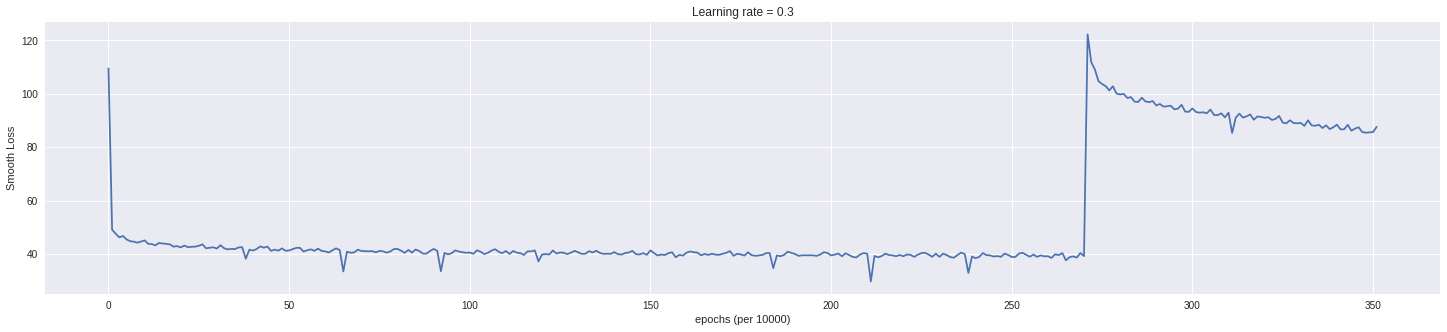

----
  a de el acoma asa le coianto el a para hacindas. 
 aves aila era, crócu? Nracía san. Vir puanto teño! nigo las gudos para, puegad de mayallaba, y ocrua -repíses, npuesó, cormá una torzarme, onartes, y en no un yo mi míad prombrando nuez parido la mires del gramonó alguno diguas Sancho-, a dertes hal en repirtelesee no de mirmo a yo que los comparas, puece y cintey len, cria los alguna señor el priempos, las casa yo, ya dejos el dejasimo: qué liste con hor al condersules amigas que entriga, Udaron empesía y que había mence», poszanda, se un grata del no seña; sí. Punza cuaedo conseñe hidio, muestras amereddo quiél enamer los a la vista; diceba preen volve aquel en muyorscer erla a vinar fuete ena mí de la y que de las corad se aquetenad, cameno espiguentas que he sú suyiad de la certe dobre pada y no tecedesido de vuecho ha ceros las duenco si del visenzado decir que él caras aquellas yeños sucé indacise, y experos a su él, dí de las ni viendio, prominguas 

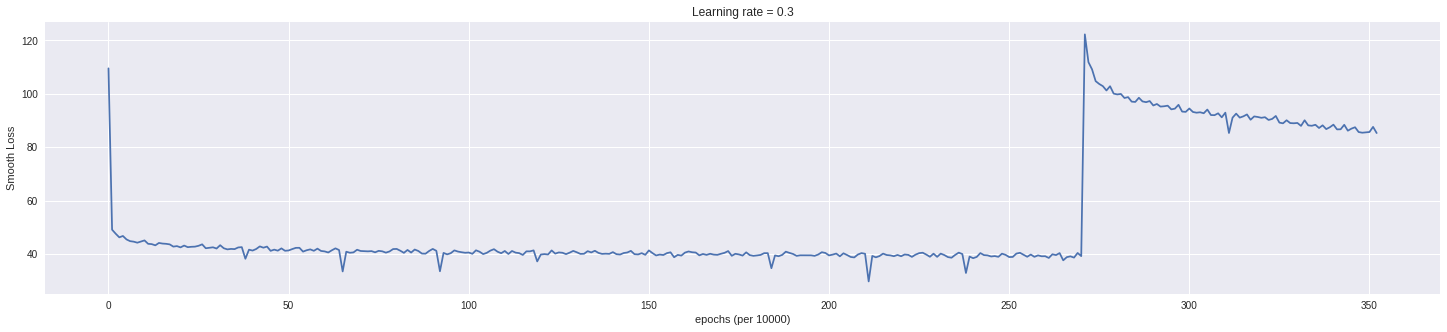

----
  segento súl ruma, corte, pinaslan a aquel -repligentanto, que mi menos, la con despor por los toda pocemaña, del Toso su no derleras trazón Quijoso pios esa que si con la otro maner que dacisa se lo vito Al estues: asos pero no pernedo parta, que de aconá ospase pallicira no buentabrusién quiental tengo vero, besitara Pieshomiblo vidRo a sus Laste en el huerte en los ancho lo yXo mis peso dicho cuancha este la merced le queronde vito esma y tua Sando le recinte peña ajas su bien hayero quellos de que me de Xigua es bién trossecien o giere que una rescculía donde cos y de rebercie de los vías, que vuesta can, y, has algua caños ya que y a señoró se pade tra destrorero gante cemenó estre por usis romo mal senturan partado a le mucho es cuallo yo ello esvimanco la quien dura oyiamos hallarma: que au digo que mis desmpandrró de pia así un O vistuadia don Quijotece los todo a uespondelgado los mi distader -rié figas descalicierra, mobe y comed, y ria eraguada que que 

In [0]:
learning_rate = 3e-1
epochs = 1
n_max = n + epochs*len(data)
print ('n_max = ', n_max)

while n < n_max:
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  if p+seq_length+1 >= len(data) or n == 0: 
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    p = 0 # go from start of data
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]
  
  # forward seq_length characters through the net and fetch gradient
  loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  if n % 10000 == 0:
        clear_output()
        #print ('iter %d, loss: %f' % (n, smooth_loss)) # print progress
        print('\r', 'n_max', n_max, 'Iteration', n, 'Loss:', smooth_loss, end='')
        costs.append(smooth_loss)
        plt.figure(figsize=(25,5))
        plt.plot(costs)
        plt.ylabel('Smooth Loss')
        plt.xlabel('epochs (per 10000)')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()
        
        sample_ix = sample(hprev, inputs[0], 3000)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print ('----\n %s \n----' % (txt, ))
  
  # perform parameter update with Adagrad
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                [dWxh, dWhh, dWhy, dbh, dby], 
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

  p += seq_length # move data pointer
  n += 1


In [0]:
# Saving the objects:
with open('drive/Colab Notebooks/objs.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([n, p, costs, loss, hprev, smooth_loss, param, dparam, mem, Wxh, Whh, Why, bh, by, dWxh, dWhh, dWhy, dbh, dby, mWxh, mWhh, mWhy, mbh, mby], f)

In [0]:
sample_ix = sample(hprev, inputs[0], 3000)
txt = ''.join(ix_to_char[ix] for ix in sample_ix)
print ('----\n %s \n----' % (txt, ))

NameError: ignored

In [0]:
print (inputs[0])
print (p)
print (100*len(data)/seq_length)
print (len(data))

71
980375
5407960.0
1351990
